In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
#from seaborn import kdeplot

import statsmodels.api as sm

-1.5996112137830105


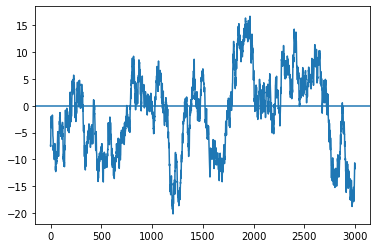

In [3]:
####Generating correlated curves:
np.random.seed(3) 
def gen_correlated_curve(rho, num=100):
    num_with_runup = num+5000
    y = np.zeros((num_with_runup,))
    for i in range(1,num_with_runup):
        y[i] = rho * y[i-1] + np.random.normal()
    return y[-num:]

timeseries = gen_correlated_curve(0.99, 3000)
print(timeseries.mean())
plt.plot(timeseries)
plt.axhline(0)

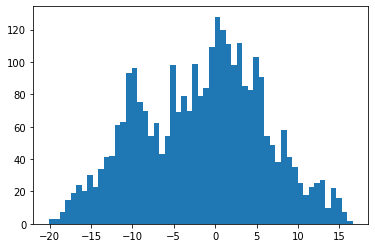

In [5]:
#kdeplot(timeseries)
_ = plt.hist(timeseries, bins=55)

now fit an AR(1) model to the timeseries. We do not assume the time series is centred on zero (because in production you won't know the centre). Hence the timeseries is shifted to zero by the 'center' parameter. Fitting the AR(1) model has the consequence of also finding where the timeseries is centred, which gives us an HPD for the timeseries mean. 

In [109]:
with pm.Model() as ar1:
    rho_ = pm.Uniform('rho',-1,1) #we assume process is stationary, so -1<k_<1
    tau_ = pm.Gamma('tau',mu=1,sd=1)
    #center = pm.Normal('center', mu=timeseries.mean(), sigma=5) #set the prior for the true mean initially centred on the population mean
    likelihood = pm.AR1('likelihood', k=rho_, tau_e=tau_, observed=timeseries)#-center)
    trace = pm.sample(target_accept=0.9)
    

INFO (theano.gof.compilelock): Refreshing lock /Users/lmar3213/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, rho]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1113.37draws/s]


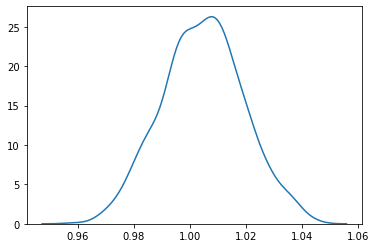

In [130]:
kdeplot(trace['tau'])

In [132]:
l =ar1['likelihood']

In [129]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
rho,0.992,0.001,0.989,0.994,0.000,0.0,688.0,687.0,674.0,517.0,1.0
tau,1.005,0.015,0.976,1.031,0.001,0.0,726.0,725.0,727.0,631.0,1.0


In [136]:
np.sqrt(1 / ((1-0.99**2)*1))

7.088812050083353

In [138]:
import theano.tensor as tt
tt.sqrt(1 / ((1-0.99**2)*1))

INFO (theano.gof.compilelock): Refreshing lock /Users/lmar3213/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock


Elemwise{sqrt,no_inplace}.0

# my own version of ar1() using correct variance:


In [2]:
import theano.tensor as tt

class fixedAR1(pm.distributions.Continuous):
    """
    Autoregressive process with 1 lag.
    Parameters
    ----------
    k: tensor
       effect of lagged value on current value
    tau_e: tensor
       precision for innovations
    """

    def __init__(self, k, tau_e, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.k = k = tt.as_tensor_variable(k)
        self.tau_e = tau_e = tt.as_tensor_variable(tau_e)
        self.tau = tau_e * (1 - k ** 2)
        self.mode = tt.as_tensor_variable(0.)

    def logp(self, x):
        """
        Calculate log-probability of AR1 distribution at specified value.
        Parameters
        ----------
        x: numeric
            Value for which log-probability is calculated.
        Returns
        -------
        TensorVariable
        """
        k = self.k
        tau_e = self.tau_e

        x_im1 = x[:-1]
        x_i = x[1:]
        
        ##removed this:
        #boundary = Normal.dist(0., tau=tau_e).logp
        ##added this:
        var_ar1 = 1 / ((1-k**2)*tau_e)
        sd_ar1 = tt.sqrt(var_ar1)
        boundary = pm.Normal.dist(0., sigma=sd_ar1).logp

        innov_like = pm.Normal.dist(k * x_im1, tau=tau_e).logp(x_i)
        return boundary(x[0]) + tt.sum(innov_like)


0.1830539309087831


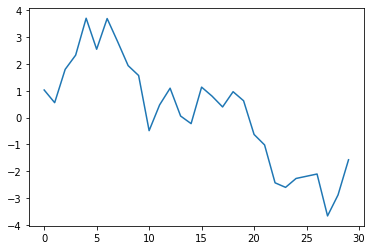

In [15]:
np.random.seed(3) 
def gen_correlated_curve(rho, num=100):
    num_with_runup = num+5000
    y = np.zeros((num_with_runup,))
    for i in range(1,num_with_runup):
        y[i] = rho * y[i-1] + np.random.normal()
    return y[-num:]

timeseries = gen_correlated_curve(0.8, 30)
print(timeseries.mean())
plt.plot(timeseries)

In [16]:
with pm.Model() as ar1:
    rho_ = pm.Uniform('rho',-1,1) #we assume process is stationary, so -1<k_<1
    tau_ = pm.Gamma('tau',mu=1,sd=1)
    center = pm.Normal('center', mu=timeseries.mean(), sigma=5) #set the prior for the true mean initially centred on the population mean
    likelihood = fixedAR1('likelihood', k=rho_, tau_e=tau_, observed=timeseries-center)
    trace = pm.sample(target_accept=0.9)
    
print(pm.stats.hpd(trace['center']))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [center, tau, rho]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1102.97draws/s]


[-4.6707604   3.34811909]


In [19]:
from statsmodels.tsa.ar_model import AutoReg
fit_result = AutoReg(timeseries-timeseries.mean(), lags = [1]).fit()
estimated_rho = fit_result.params[1]

In [20]:
estimated_rho

0.8948917843003408

In [17]:
pm.stats.hpd(trace['center'])

array([-4.6707604 ,  3.34811909])

In [18]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
center,0.022,2.041,-4.671,3.348,0.128,0.115,256.0,159.0,342.0,242.0,1.01
rho,0.882,0.074,0.756,0.999,0.004,0.003,419.0,404.0,364.0,356.0,1.01
tau,1.135,0.282,0.605,1.628,0.011,0.008,700.0,700.0,687.0,790.0,1.00


# Trying a custom AR(1):

See: https://stats.stackexchange.com/questions/346747/pymc3-using-ar1-process-as-prior-causes-bad-initial-energy-error


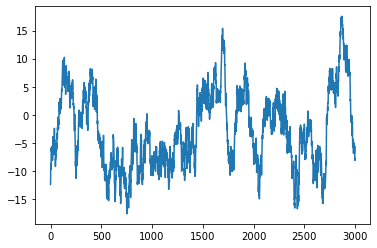

In [66]:

from scipy import stats
np.random.seed(2) 
def simple_ar(n_samples, k, sig, mu):
    n = n_samples+5000
    out = np.zeros((n,), dtype='float64')
    out[0] = mu

    for i in range(1, n):
        out[i] = k * (out[i-1] - mu) + stats.norm.rvs(scale=sig, size=(1,)) + mu

    return out[-n_samples:]

out = simple_ar(3000, 0.99, 1,0)
plt.plot(out)

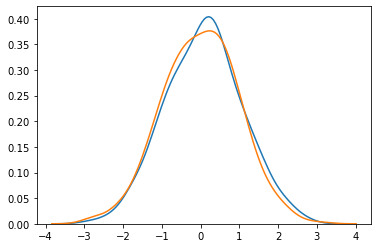

In [65]:
kdeplot(stats.norm.rvs(scale=1, size=(1000,)))
kdeplot([np.random.normal() for _ in range(1000)])

In [56]:
np.random.seed(2) 
def simple_ar(n_samples, k, sig, mu):
    n = n_samples+5000
    out = np.zeros((n,), dtype='float64')
    out[0] = mu

    for i in range(1, n):
        out[i] = k * (out[i-1] - mu) + np.random.normal() + mu

    return out[-n_samples:]

out = simple_ar(3000, 0.99, 0, 0)
print(np.mean(out))

-2.7112278332640463


In [68]:
import theano as T
import theano.tensor as tt
import pymc3 as pm
from pymc3.distributions.distribution import generate_samples, draw_values

class NonzeroMeanAR1(pm.distributions.continuous.PositiveContinuous):
    """
    Autoregressive process with 1 lag.
    Parameters
    ----------
    k : tensor
       effect of lagged value on current value
    tau_e : tensor
       precision for innovations
    """

    def __init__(self, k, tau_e, mu, *args, **kwargs):
        super(NonzeroMeanAR1, self).__init__(*args, **kwargs)
        self.k = k = tt.as_tensor_variable(k)
        self.tau_e = tau_e = tt.as_tensor_variable(tau_e)
        self.tau = tau_e * (1 - k ** 2)
        self.mu = tt.as_tensor_variable(mu)
        #self.mode = tt.as_tensor_variable(0.)
        self.mean = self.mu

    def logp(self, x):
        k = self.k
        tau_e = self.tau_e
        mu = self.mu

        x_im1 = x[:-1]
        x_i = x[1:]
        boundary = pm.Normal.dist(mu=mu, tau=tau_e).logp(x[0])

        innov_like = pm.Normal.dist(mu=k * (x_im1 - mu) + mu, tau=tau_e).logp(x_i)
        return boundary + tt.sum(innov_like)

    def random(self, point=None, size=None):
        tau = draw_values([self.tau], point=point)[0]
        mu = draw_values([self.mu], point=point)[0]
        k = draw_values([self.k], point=point)[0]
        eps = generate_samples(sps.norm.rvs, loc=0, scale=tau**-0.5,
                               dist_shape=self.shape,
                               size=size)

        y, _ = T.scan(lambda err, prev, k, mu: k*(prev - mu) + mu + err,
                      outputs_info=mu*tt.ones((1,), dtype='float64'),
                      sequences=[eps],
                      non_sequences=[k, mu])

        return y

In [72]:
import scipy.stats as sps
def simple_ar(n_samples, k, sig, mu):
    out = np.zeros((n_samples,), dtype='float64')
    out[0] = mu

    for i in range(1, n_samples):
        out[i] = k * (out[i-1] - mu) + sps.norm.rvs(scale=sig, size=(1,)) + mu

    return out

y_obs = simple_ar(500, 0.9, 0.2, 100)


In [73]:
with pm.Model() as ar1:
    rho_ = pm.Uniform('rho',-1,1) #we assume process is stationary, so -1<k_<1
    tau_ = pm.Gamma('tau',mu=1,sd=1)
    center = pm.Normal('center', mu=y_obs.mean(), sigma=5) #set the prior for the true mean initially centred on the population mean
    likelihood = NonzeroMeanAR1('likelihood', k=rho_, tau_e=tau_, mu = center, observed=y_obs)
    trace = pm.sample(target_accept=0.9)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [center, tau, rho]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1382.62draws/s]


In [74]:
pm.stats.hpd(trace['center'])

array([ 99.81455361, 100.11587332])

In [79]:
with pm.Model() as ar_model:
    k = pm.HalfFlat('k')
    tau = pm.HalfNormal('tau', sd=100)
    mu = pm.HalfFlat('mu')
    y = pm.AR1('y', k=k, tau_e=tau, observed=y_obs-mu)
    trace = pm.sample(1000, tune=500)
    
print(pm.stats.hpd(trace['center']))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, tau, k]
Sampling 2 chains, 458 divergences: 100%|██████████| 3000/3000 [00:10<00:00, 280.39draws/s]
The acceptance probability does not match the target. It is 0.9969080540395997, but should be close to 0.8. Try to increase the number of tuning steps.
There were 458 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.021620788614304186, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


KeyError: 'Unknown variable center'

INFO (theano.gof.compilelock): Refreshing lock /Users/lmar3213/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [center, tau, rho]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1173.06draws/s]


[-3.36843079  0.67438619]


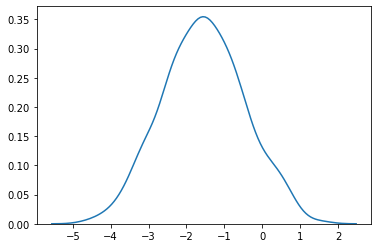

In [82]:
ts = timeseries+10
with pm.Model() as ar1:
    rho_ = pm.Uniform('rho',-1,1) #we assume process is stationary, so -1<k_<1
    tau_ = pm.Gamma('tau',mu=1,sd=1)
    center = pm.Normal('center', mu=ts.mean(), sigma=5) #set the prior for the true mean initially centred on the population mean
    likelihood = pm.AR1('likelihood', k=rho_, tau_e=tau_, observed=ts-center)
    trace = pm.sample(target_accept=0.9)
    
print(pm.stats.hpd(trace['center']))
kdeplot(trace['center'])

# Analysis:


In [14]:
#HPD is way off:
pm.stats.hpd(trace['center'])

array([-13.55096279,  -9.67315923])

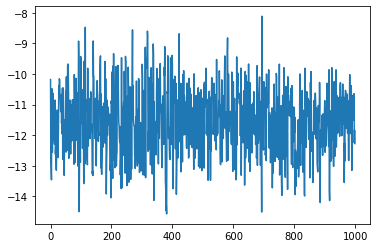

In [6]:
#Trajectory looks OK:
plt.plot(trace['center'])

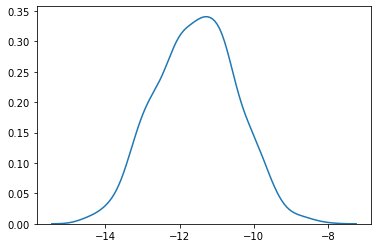

In [7]:
#it's definitely got lost:
kdeplot(trace['center'])

# Comparison to other measures:

In [161]:
#Now we can compare to another technique, based on the autocorrelation function. This is from 
#Use of the Weighted Histogram Analysis Method for the Analysis of Simulated and Parallel Tempering Simulations
#First it calculates the autocorrelation time constant, then calculates SEM based on 'effective number of samples'
#then just apply the 95 CI to that SEM. 
z95 = 1.959963984540054

#this is the Chodera lab 'statistical inefficiency' measure.
def statistical_inefficiency(corr, mintime=3):
    N = corr.size
    C_t = sm.tsa.stattools.acf(corr, fft=True, unbiased=True, nlags=N)
    t_grid = np.arange(N).astype('float')
    g_t = 2.0 * C_t * (1.0 - t_grid / float(N))
    ind = np.where((C_t <= 0) & (t_grid > mintime))[0][0]
    g = 1.0 + g_t[1:ind].sum()
    return max(1.0, g)

 #and these actually return the values for SEM:
def ci_from_chodera(timeseries):
    autocorrelation_time = statistical_inefficiency(timeseries)
    #original n
    n = len(timeseries)
    #calculate SEM and return CI using effective n:
    sem = np.std(timeseries) / np.sqrt(n/autocorrelation_time)
    #return CI:
    return timeseries.mean()-sem*z95, timeseries.mean()+sem*z95

print(sem_from_chodera(timeseries))

(-5.056946809414023, 1.8577243818480016)
